<a href="https://colab.research.google.com/github/atharvanaik10/screentime/blob/main/ScreenTime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualization of actor screentime in a given movie clip using deep learning


## Project Goals:


A neural network is trained to detect faces in a frame (image) and output the faces in the image. 
* We use `OpenCV` to extract individual frames from the movie clip
* We use `MTCNN` (multitask cascaded convolutional neural network) to extract faces for each frame

Another neural network is trained on a dataset of faces of Bollywood actors to recognize and classify faces. 
* We use `FaceNet` (wrapped in `keras`) to extract face mappings
* We use `scikit-learn` to develop a classifier for our faces

[More information about face recognition](https://docs.google.com/document/d/1598xceIfkDeDQmPRQhCrsC8KbZ0vLFTGVJUl3PAp99o/edit?usp=sharing)

We use this classification of faces for each actor for each frame in the given movie clip to calculate the frequencies (# of frames) each actor appears in. 
* This is done using vanilla `Python` with `Numpy`

We then visualize this data to show actor screentime percentage.
* We use `Numpy` and `matplotlib` to compile and visualize data

NOTE: To run this locally, you will have to change all absolute filepaths here to your respective filepaths.


## Imports
0. Import necessary libraries and methods

In [ ]:
# Imports
from google.colab import drive
drive.mount('/gdrive')

!pip install mtcnn
!pip install nolearn
from mtcnn.mtcnn import MTCNN
from tensorflow import keras
import sklearn
import sklearn.preprocessing
import sklearn.svm
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from os import listdir
from os.path import isdir

import PIL.Image
import cv2
import matplotlib
import numpy as np
import pandas
import matplotlib.pyplot as plt
import pickle

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


## Face and feature extraction
1. Extract faces from our dataset. We use a dataset of the top 100 bollywood actors: (https://www.kaggle.com/datasets/havingfun/100-bollywood-celebrity-faces)

2. Use facenet to extract features from each class face

In [ ]:
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
	# load image from file
	pixels = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
	# detect faces in the image
	results = detector.detect_faces(pixels)
 
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height

	face = pixels[y1:y2, x1:x2]
	image = PIL.Image.fromarray(face).resize(required_size)
	face_array = np.asarray(image)
 
	return face_array
 
# load images and extract a single face for all images in a directory
def load_face(directory):
	faces = []
	fail_count = 0
	for filename in listdir(directory):
		path = directory + filename
		try:
			face = extract_face(path)
			faces.append(face)
		except:
			fail_count += 1
	return faces, fail_count
 
# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory, test_size):
	trainX, trainy = [],[]
	testX, testy = [], []

	for subdir in listdir(directory):
		path = directory + '/' + subdir + '/'
		# skip any files that might be in the dir
		if not isdir(path):
			continue
		
		# load all faces in the subdirectory
		faces, fail_count = load_faces(path)
		labels = [subdir for idx in range(len(faces))]

		# summarize progress
		print('> Loaded %d and failed %d faces for class: %s' % (len(faces), fail_count, subdir))
	
		# store the first [test_size] images as test data, rest as training data
		testX.extend(faces[0:test_size])
		testy.extend(labels[0:test_size])
		trainX.extend(faces[test_size:])
		trainy.extend(labels[test_size:])
	 
	return np.asarray(trainX), np.asarray(trainy), np.asarray(testX), np.asarray(testy)

In [ ]:
# create the detector, using default weights
detector = MTCNN()

# load dataset
# TODO: relative filepath
TEST_SIZE = 20
trainX, trainy, testX, testy = load_dataset('/gdrive/MyDrive/Sem4/CWL207/2022_207_Group_21/dataset/subset_bollywood_faces', TEST_SIZE)

print(trainX.shape, trainy.shape)
print('Datasets loaded')

# store faces
pickle.dump(trainX, open('/gdrive/MyDrive/Sem4/CWL207/2022_207_Group_21/dataset/pickle/trainX.pkl', 'wb'))
pickle.dump(trainy, open('/gdrive/MyDrive/Sem4/CWL207/2022_207_Group_21/dataset/pickle/trainy.pkl', 'wb'))
pickle.dump(testX, open('/gdrive/MyDrive/Sem4/CWL207/2022_207_Group_21/dataset/pickle/testX.pkl', 'wb'))
pickle.dump(testy, open('/gdrive/MyDrive/Sem4/CWL207/2022_207_Group_21/dataset/pickle/testy.pkl', 'wb'))
print('Faces stored')

In [ ]:
# unpickle faces
trainX = pickle.load(open('/gdrive/MyDrive/Sem4/CWL207/2022_207_Group_21/dataset/pickle/trainX.pkl', 'rb'))
trainy = pickle.load(open('/gdrive/MyDrive/Sem4/CWL207/2022_207_Group_21/dataset/pickle/trainy.pkl', 'rb'))
testX = pickle.load(open('/gdrive/MyDrive/Sem4/CWL207/2022_207_Group_21/dataset/pickle/testX.pkl', 'rb'))
testy = pickle.load(open('/gdrive/MyDrive/Sem4/CWL207/2022_207_Group_21/dataset/pickle/testy.pkl', 'rb'))

In [ ]:
# calculate features using facenet

def get_embedding(model, face):
  face = face.astype('float32')
  face = face-face.mean()/face.std()

  yhat = model.predict(np.expand_dims(face, axis=0))
  return yhat[0]

In [ ]:
# convert train and test data into feature arrays
model = keras.models.load_model('/gdrive/MyDrive/Sem4/CWL207/2022_207_Group_21/dataset/keras-facenet/model/facenet_keras.h5')

trainX_features = []
testX_features = []

for face in trainX:
  trainX_features.append(get_embedding(model, face))
trainX_features = np.asarray(trainX_features)

for face in testX:
  testX_features.append(get_embedding(model, face))
testX_features = np.asarray(testX_features)


## Training
3. Train a classifier using train data and test data

In [ ]:
# develop a classifier

# normalize input vectors
encoder = sklearn.preprocessing.Normalizer(norm='l2')

# TODO: dump these
trainX_features = encoder.transform(trainX_features)
testX_features = encoder.transform(testX_features)

# encode label targets (converts labels from strings to ints)
# encoder = sklearn.preprocessing.LabelEncoder()
# encoder.fit(trainy)
# trainy_encoded = encoder.transform(trainy)
# testy_encoded = encoder.transform(testy)

# fit model
classifier_model = sklearn.svm.SVC(C=10, kernel='rbf',probability=True, gamma=5)
classifier_model.fit(trainX_features, trainy)

# dump model
pickle.dump(classifier_model, open('/gdrive/MyDrive/Sem4/CWL207/2022_207_Group_21/dataset/pickle/classifier_model.pkl', 'wb'))

In [ ]:
# test model on test data
classifier_model = pickle.load(open('/gdrive/MyDrive/Sem4/CWL207/2022_207_Group_21/dataset/pickle/classifier_model.pkl', 'rb'))

preds = classifier_model.predict(testX_features)

print("Testing complete with " + str(sklearn.metrics.accuracy_score(testy, preds)) + " accuracy")


Testing complete with 0.64 accuracy


## Input processing
4. Process input video clip into inout data with one frame from each second of video


In [ ]:
def extract_frames(in_file, out_folder):
  step = 1000 #in milliseconds

  # read and store one frame from each second of video into out_folder 
  cap = cv2.VideoCapture(in_file)
  success = True
  frame = 0
  success, image = cap.read()
  while success:
    cap.set(cv2.CAP_PROP_POS_MSEC, frame * step)
    cv2.imwrite(out_folder + ('_%d.jpg' % frame), image)
    frame += 1
    success, image = cap.read()
  return 


In [ ]:
# for each video clip, store frames in a new folder
in_file = "/gdrive/MyDrive/Sem4/CWL207/2022_207_Group_21/dataset/clips/clip2.mp4"
out_folder = "/gdrive/MyDrive/Sem4/CWL207/2022_207_Group_21/dataset/extracted_frames/clip2"

extract_frames(in_file, out_folder)

## Prediction

In [ ]:
# extract all faces from a given photograph
def extract_faces(filename, required_size=(160, 160)):
	pixels = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)

	# pixels = cv2.resize(pixels, (800, 800))
	faces = detector.detect_faces(pixels)
	faces_array = []
	for idx in range(len(faces)):
		# extract the bounding box from the face
		x1, y1, width, height = faces[idx]['box']
		x1, y1 = abs(x1), abs(y1)
		x2, y2 = x1 + width, y1 + height

		face = pixels[y1:y2, x1:x2]

		# resize pixels to the model size
		image = PIL.Image.fromarray(face).resize(required_size)

		face_array = np.asarray(image)
		faces_array.append(face_array)

	return np.asarray(faces_array)
 
# load images and extract faces for all images in a directory
def load_faces(directory):
	# frame_faces of the form dict(): int frame -> faces[]
	frame_faces = {}

	fail_count = 0
	frame_count = 0
	for filename in listdir(directory):
		path = directory + filename
		try:
			faces = extract_faces(path)
			frame_faces[frame_count] = faces
		except:
			fail_count += 1
			frame_faces[frame_count] = None
		# faces = extract_faces(path)
		# frame_faces[frame_count] = faces
		frame_count += 1
	return frame_faces, fail_count

In [ ]:
# for the folder of frames, get faces of each frame
detector = MTCNN()
classifier = pickle.load(open('/gdrive/MyDrive/Sem4/CWL207/2022_207_Group_21/dataset/pickle/classifier_model.pkl', 'rb'))
frame_folder = "/gdrive/MyDrive/Sem4/CWL207/2022_207_Group_21/dataset/extracted_frames/"


frame_faces, fail_count = load_faces(frame_folder)
print(len(frame_faces))
print(fail_count)

87
0


In [ ]:
print(np.shape(frame_faces[1]))

(1, 160, 160, 3)


In [ ]:
model = keras.models.load_model('/gdrive/MyDrive/Sem4/CWL207/2022_207_Group_21/dataset/keras-facenet/model/facenet_keras.h5')
encoder = sklearn.preprocessing.Normalizer(norm='l2')

frame_preds = {}
# for each frame
for key in frame_faces:
  if(len(frame_faces[key] != 0)):
    embedded = []
    for face in frame_faces[key]:
      embedded.append(get_embedding(model, face))
    embedded = np.asarray(embedded)
    embedded = encoder.transform(embedded)
    preds = classifier.predict(embedded)
    frame_preds[key] = preds
    print(str(key) ,": ", preds)


0 :  ['Kareena_Kapoor']
1 :  ['Kareena_Kapoor']
2 :  ['Shah_Rukh_Khan' 'Kareena_Kapoor' 'Hrithik_Roshan']
3 :  ['Amitabh_Bachchan']
4 :  ['Kajol']
5 :  ['Hrithik_Roshan' 'Kareena_Kapoor']
6 :  ['Hrithik_Roshan' 'Hrithik_Roshan' 'Hrithik_Roshan']
7 :  ['Hrithik_Roshan' 'Hrithik_Roshan' 'Hrithik_Roshan']
8 :  ['Hrithik_Roshan' 'Hrithik_Roshan' 'Kareena_Kapoor']
9 :  ['Shah_Rukh_Khan']
10 :  ['Shah_Rukh_Khan']
11 :  ['Hrithik_Roshan']
12 :  ['Shah_Rukh_Khan']
13 :  ['Hrithik_Roshan']
14 :  ['Hrithik_Roshan']
15 :  ['Hrithik_Roshan']
16 :  ['Hrithik_Roshan']
17 :  ['Hrithik_Roshan']
18 :  ['Hrithik_Roshan']
19 :  ['Amitabh_Bachchan']
20 :  ['Kajol']
21 :  ['Kajol']
22 :  ['Hrithik_Roshan']
23 :  ['Kajol']
24 :  ['Kareena_Kapoor' 'Hrithik_Roshan']
25 :  ['Hrithik_Roshan' 'Hrithik_Roshan']
26 :  ['Hrithik_Roshan' 'Hrithik_Roshan']
27 :  ['Hrithik_Roshan' 'Amitabh_Bachchan']
28 :  ['Hrithik_Roshan']
29 :  ['Hrithik_Roshan']
30 :  ['Hrithik_Roshan']
31 :  ['Hrithik_Roshan']
32 :  ['Hrithik_Ros

## Analysis and visualization

{'Kareena_Kapoor': 28, 'Shah_Rukh_Khan': 7, 'Hrithik_Roshan': 82, 'Amitabh_Bachchan': 5, 'Kajol': 11}


<BarContainer object of 5 artists>

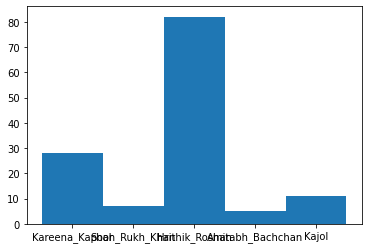

In [ ]:
# graph frequencies using matplotlib

frequencies = {}

for key in frame_preds:
  for actor in frame_preds[key]:
    try:
      frequencies[actor] += 1
    except KeyError:
      frequencies[actor] = 1

print(frequencies)
# df = pandas.DataFrame.from_dict(frequencies)
# df.plot.bar
plt.bar(frequencies.keys(), frequencies.values(), 1)

### Analysis and next steps:

- We have successfully demonstrated, as a proof of concept, the ability to extract the frequencies that actors appear in a given clip

- Our classifier model, unfortunately, has a low accuracy of ~76% on test data, because of the fact that most classifiers are trained on caucasian faces. Because of this, South Asian faces become hard to extract and recognize

- Next steps include working to create better classification models, using more training data, and testing this with longer clips. 